In [62]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from numpy.random import seed
from tensorflow.random import set_seed
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 열 최대 너비 설정
pd.options.display.max_colwidth = 100

In [4]:
seed(42)
random.seed(42)
set_seed(42)

In [5]:
os.environ['PYTHONHASHSEED']= str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [6]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# 파일 불러오기
main_path = '/content/drive/MyDrive/chest_xray'

train_path = os.path.join(main_path, 'train')
test_path = os.path.join(main_path, 'test')

In [9]:
train_normal = glob.glob(train_path+'/NORMAL/*.jpeg')
test_normal = glob.glob(test_path+'/NORMAL/*.jpeg')

train_pneumonia = glob.glob(train_path+'/PNEUMONIA/*.jpeg')
test_pneumonia = glob.glob(test_path+'/PNEUMONIA/*.jpeg')

In [10]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

In [11]:
df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal),
                                        ['Pneumonia']*len(train_pneumonia)]),
                        columns = ['class'])

In [12]:
df_train['image'] = [x for x in train_list]

In [13]:
test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

In [14]:
df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal),
                                       ['Pneumonia']*len(test_pneumonia)]),
                       columns = ['class'])

In [15]:
df_test['image'] = [x for x in test_list]

In [16]:
df_train

class  \
0        Normal   
1        Normal   
2        Normal   
3        Normal   
4        Normal   
...         ...   
5227  Pneumonia   
5228  Pneumonia   
5229  Pneumonia   
5230  Pneumonia   
5231  Pneumonia   

                                                                             image  
0          /content/drive/MyDrive/chest_xray/train/NORMAL/NORMAL-3411116-0001.jpeg  
1          /content/drive/MyDrive/chest_xray/train/NORMAL/NORMAL-3399582-0001.jpeg  
2          /content/drive/MyDrive/chest_xray/train/NORMAL/NORMAL-3400382-0001.jpeg  
3          /content/drive/MyDrive/chest_xray/train/NORMAL/NORMAL-3400382-0002.jpeg  
4           /content/drive/MyDrive/chest_xray/train/NORMAL/NORMAL-339692-0001.jpeg  
...                                                                            ...  
5227  /content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA-4233560-0002.jpeg  
5228  /content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA-4238020-0001.jpeg  
5229  /content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA-4198099-0001.jpeg  
5230  /content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA-4233560-0001.jpeg  
5231  /content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA-4213815-0003.jpeg  

[5232 rows x 2 columns]

In [17]:
df_test

class  \
0        Normal   
1        Normal   
2        Normal   
3        Normal   
4        Normal   
..          ...   
619  Pneumonnia   
620  Pneumonnia   
621  Pneumonnia   
622  Pneumonnia   
623  Pneumonnia   

                                                                           image  
0         /content/drive/MyDrive/chest_xray/test/NORMAL/NORMAL-1110860-0001.jpeg  
1         /content/drive/MyDrive/chest_xray/test/NORMAL/NORMAL-1318320-0001.jpeg  
2         /content/drive/MyDrive/chest_xray/test/NORMAL/NORMAL-1160949-0001.jpeg  
3         /content/drive/MyDrive/chest_xray/test/NORMAL/NORMAL-1283091-0001.jpeg  
4         /content/drive/MyDrive/chest_xray/test/NORMAL/NORMAL-1049278-0001.jpeg  
..                                                                           ...  
619  /content/drive/MyDrive/chest_xray/test/PNEUMONIA/BACTERIA-9913238-0002.jpeg  
620  /content/drive/MyDrive/chest_xray/test/PNEUMONIA/BACTERIA-9857270-0002.jpeg  
621  /content/drive/MyDrive/chest_xray/test/PNEUMONIA/BACTERIA-9673743-0001.jpeg  
622     /content/drive/MyDrive/chest_xray/test/PNEUMONIA/VIRUS-1207991-0001.jpeg  
623      /content/drive/MyDrive/chest_xray/test/PNEUMONIA/VIRUS-131422-0001.jpeg  

[624 rows x 2 columns]

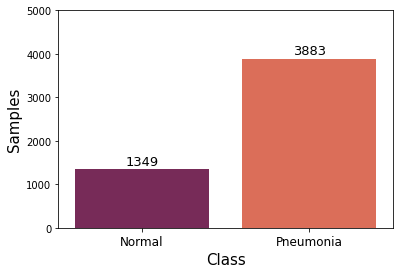

In [18]:
# train 데이터 분포 확인
plt.figure(figsize=(6, 4))

ax = sns.countplot(x = 'class', data = df_train, palette = 'rocket')

plt.xlabel('Class', fontsize = 15)
plt.ylabel('Samples', fontsize = 15)
plt.ylim(0, 5000)
plt.xticks([0, 1], ['Normal', 'Pneumonia'], fontsize = 12)

for p in ax.patches:
  ax.annotate((p.get_height()),
              (p.get_x()+0.3, 
               p.get_height()+100),
              fontsize = 13)
plt.show()

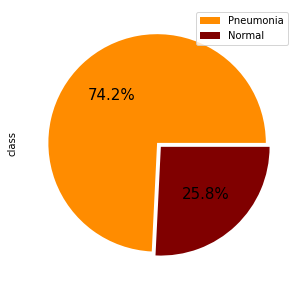

In [19]:
plt.figure(figsize=(7, 5))

df_train['class'].value_counts().plot(kind='pie', labels = ['', ''], autopct = '%1.1f%%',
                                      colors = ['darkorange', 'maroon'], explode = [0, 0.05], 
                                      textprops = {'fontsize':15})

plt.legend(labels = ['Pneumonia', 'Normal'])
plt.show()

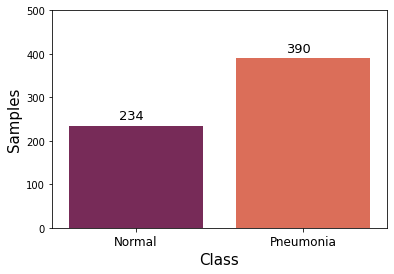

In [20]:
# test 데이터 분포 확인
plt.figure(figsize=(6, 4))

ax = sns.countplot(x = 'class', data = df_test, palette = 'rocket')

plt.xlabel('Class', fontsize = 15)
plt.ylabel('Samples', fontsize = 15)
plt.ylim(0, 500)
plt.xticks([0, 1], ['Normal', 'Pneumonia'], fontsize = 12)

for p in ax.patches:
  ax.annotate((p.get_height()),
              (p.get_x()+0.3, 
               p.get_height()+15),
              fontsize = 13)
plt.show()

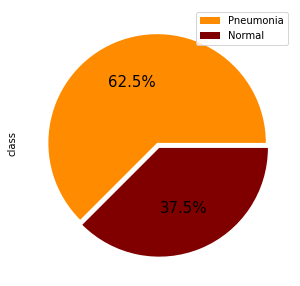

In [21]:
plt.figure(figsize=(7, 5))

df_test['class'].value_counts().plot(kind='pie', labels = ['', ''], autopct = '%1.1f%%',
                                      colors = ['darkorange', 'maroon'], explode = [0, 0.05], 
                                      textprops = {'fontsize':15})

plt.legend(labels = ['Pneumonia', 'Normal'])
plt.show()

train, test 둘 다 약간 불균형

폐렴이 더 많은 샘플

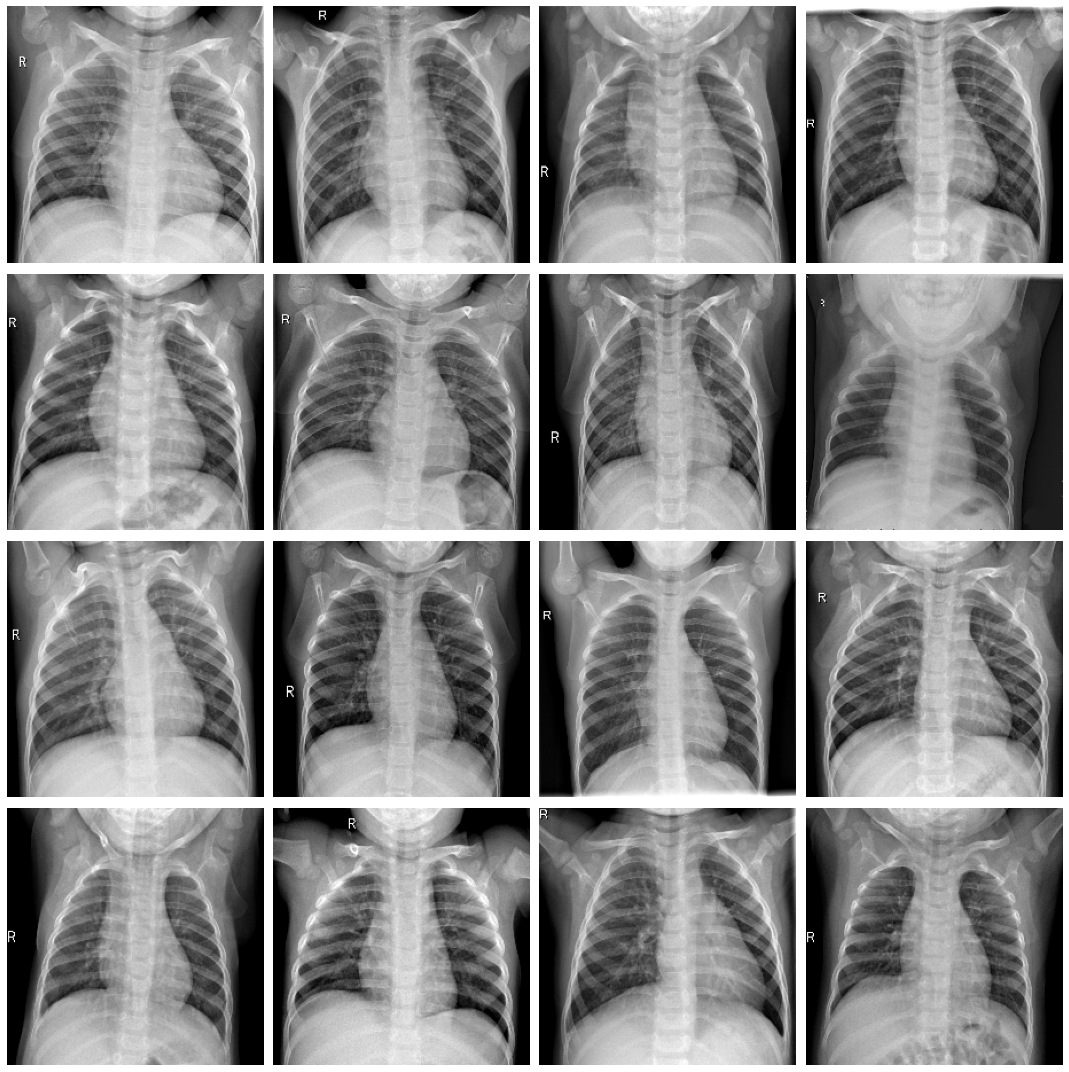

In [22]:
# train 중 정상 폐 샘플 예시
plt.figure(figsize=(15, 15))

for i in range(0, 16):
  plt.subplot(4, 4, i + 1)
  img = cv2.imread(train_normal[i])
  img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
  plt.imshow(img)
  plt.axis('off')

plt.tight_layout()
plt.show()

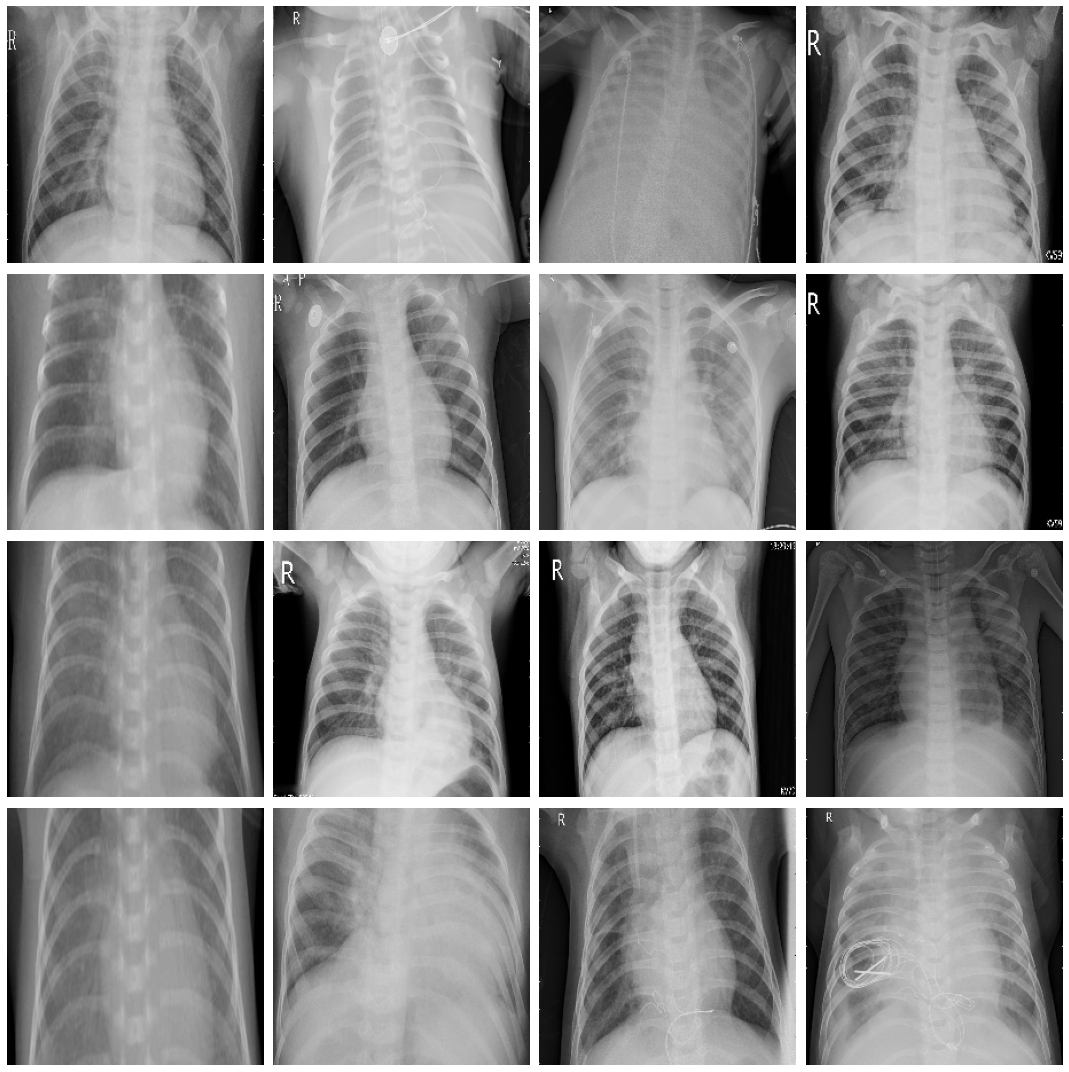

In [23]:
# train 중 폐렴 폐 샘플 예시
plt.figure(figsize=(15, 15))

for i in range(0, 16):
  plt.subplot(4, 4, i + 1)
  img = cv2.imread(train_pneumonia[i])
  img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
  plt.imshow(img)
  plt.axis('off')

plt.tight_layout()
plt.show()

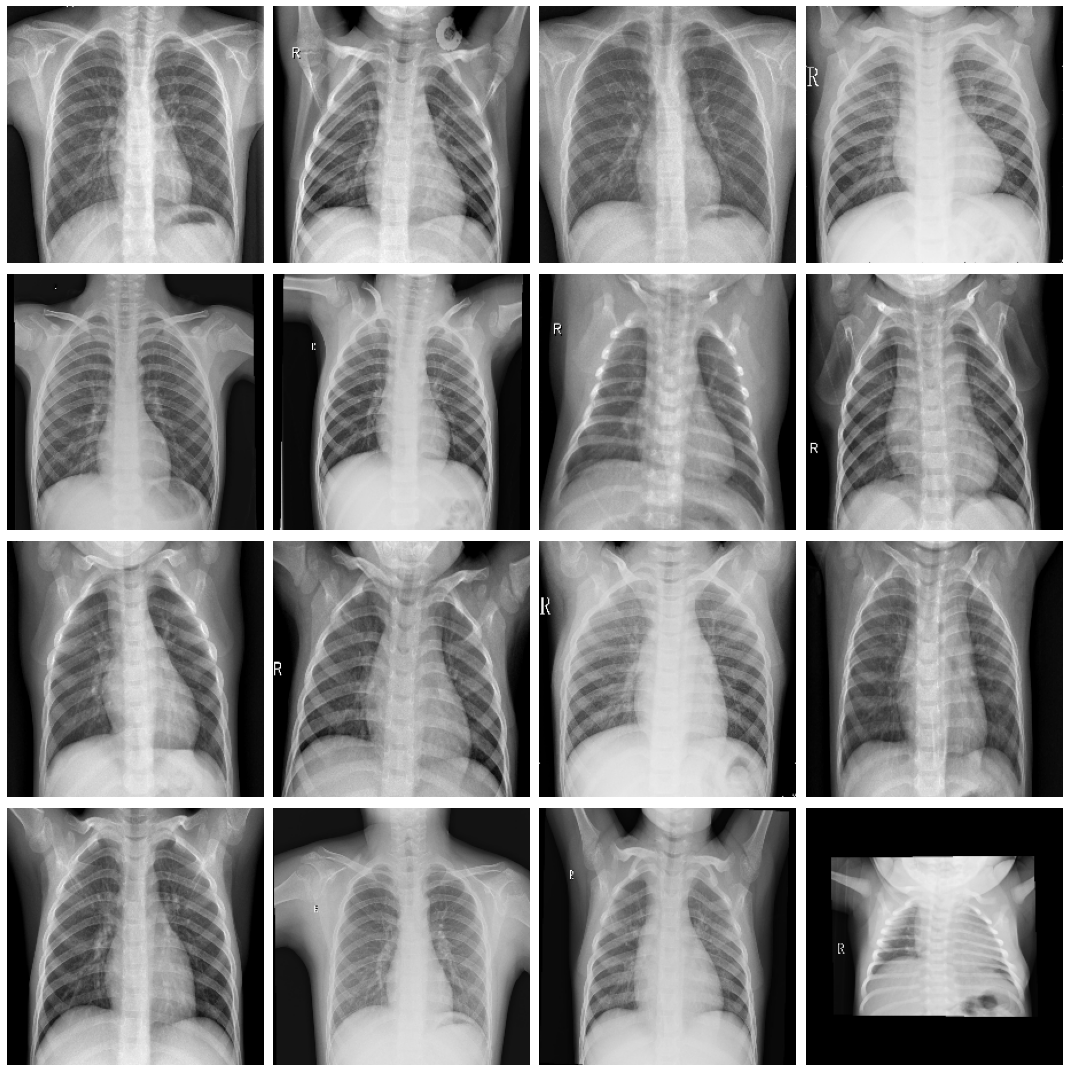

In [24]:
# test 중 정상 폐 샘플 예시
plt.figure(figsize=(15, 15))

for i in range(0, 16):
  plt.subplot(4, 4, i + 1)
  img = cv2.imread(test_normal[i])
  img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
  plt.imshow(img)
  plt.axis('off')

plt.tight_layout()
plt.show()

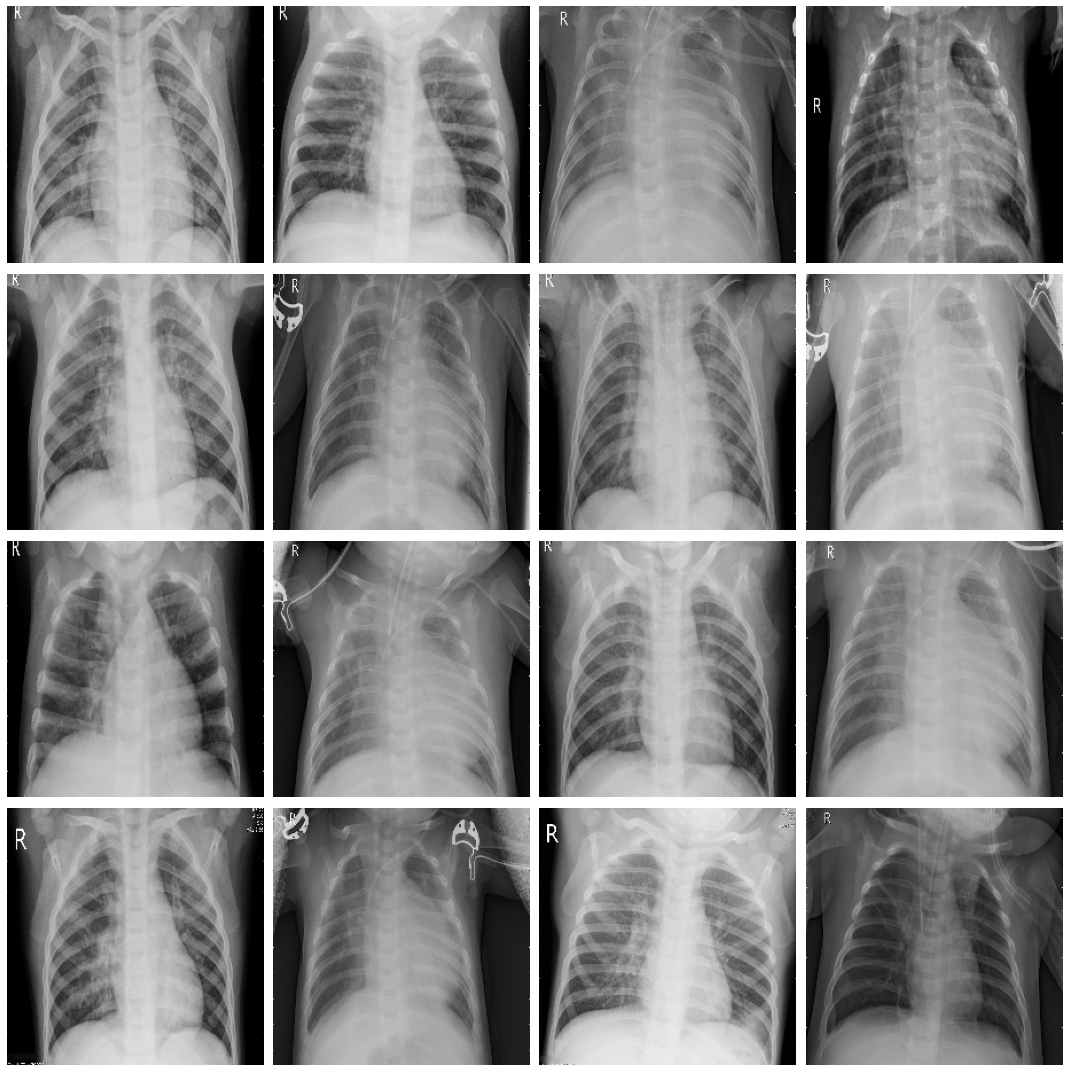

In [25]:
# test 중 폐렴 폐 샘플 예시
plt.figure(figsize=(15, 15))

for i in range(0, 16):
  plt.subplot(4, 4, i + 1)
  img = cv2.imread(test_pneumonia[i])
  img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
  plt.imshow(img)
  plt.axis('off')

plt.tight_layout()
plt.show()

In [26]:
# 데이터 분할
train_df, val_df = train_test_split(df_train, test_size = 0.2, random_state = SEED, stratify = df_train['class'])

In [27]:
train_df

class  \
3566  Pneumonia   
2866  Pneumonia   
2681  Pneumonia   
1199     Normal   
4619  Pneumonia   
...         ...   
3476  Pneumonia   
678      Normal   
1560  Pneumonia   
2769  Pneumonia   
4881  Pneumonia   

                                                                             image  
3566  /content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA-4991468-0001.jpeg  
2866  /content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA-9424776-0004.jpeg  
2681    /content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA-86966-0002.jpeg  
1199       /content/drive/MyDrive/chest_xray/train/NORMAL/NORMAL-2395964-0001.jpeg  
4619  /content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA-2024553-0001.jpeg  
...                                                                            ...  
3476  /content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA-4615614-0002.jpeg  
678        /content/drive/MyDrive/chest_xray/train/NORMAL/NORMAL-7943300-0001.jpeg  
1560     /content/drive/MyDrive/chest_xray/train/PNEUMONIA/VIRUS-4757979-0002.jpeg  
2769  /content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA-9044474-0005.jpeg  
4881  /content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA-2982508-0001.jpeg  

[4185 rows x 2 columns]

In [28]:
val_df

class  \
2945  Pneumonia   
4878  Pneumonia   
3177  Pneumonia   
972      Normal   
3059  Pneumonia   
...         ...   
253      Normal   
4315  Pneumonia   
687      Normal   
3417  Pneumonia   
3745  Pneumonia   

                                                                             image  
2945  /content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA-9634181-0001.jpeg  
4878  /content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA-2979486-0001.jpeg  
3177     /content/drive/MyDrive/chest_xray/train/PNEUMONIA/VIRUS-2365050-0002.jpeg  
972        /content/drive/MyDrive/chest_xray/train/NORMAL/NORMAL-9814816-0001.jpeg  
3059     /content/drive/MyDrive/chest_xray/train/PNEUMONIA/VIRUS-1335423-0004.jpeg  
...                                                                            ...  
253         /content/drive/MyDrive/chest_xray/train/NORMAL/NORMAL-506998-0001.jpeg  
4315  /content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA-7620642-0003.jpeg  
687        /content/drive/MyDrive/chest_xray/train/NORMAL/NORMAL-7953615-0001.jpeg  
3417  /content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA-4396545-0001.jpeg  
3745  /content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA-5454799-0002.jpeg  

[1047 rows x 2 columns]

In [29]:
# 픽셀 값 재조정하고 데이터 증대
train_generator = ImageDataGenerator(rescale = 1/255., 
                                     zoom_range = 0.1, 
                                     width_shift_range = 0.1, 
                                     height_shift_range = 0.1)
val_generator = ImageDataGenerator(rescale = 1/255.)

In [30]:
# generator 적용
ds_train = train_generator.flow_from_dataframe(train_df, x_col = 'image', y_col = 'class', 
                                               target_size = (IMG_SIZE, IMG_SIZE), class_mode = 'binary', 
                                               batch_size = BATCH, seed = SEED)
ds_val = val_generator.flow_from_dataframe(val_df, x_col = 'image', y_col = 'class', 
                                           target_size = (IMG_SIZE, IMG_SIZE), class_mode = 'binary', 
                                           batch_size = BATCH, seed = SEED)
ds_test = val_generator.flow_from_dataframe(df_test, x_col = 'image', y_col = 'class', 
                                            target_size = (IMG_SIZE, IMG_SIZE), class_mode = 'binary',
                                            batch_size = 1, shuffle = False)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [31]:
# callback 설정
early_stopping = callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 5, 
    min_delta = 1e-7,
    restore_best_weights = True
)

reduce_plateau = callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    patience = 2,
    min_delt = 1e-7,
    cooldown = 0,
    verbose =1
)

In [32]:
# 이미지 분류 모델 만들기
def get_model():
  inputs = layers.Input(shape = (IMG_SIZE, IMG_SIZE, 3)) # width, height, color channels

  x = layers.Conv2D(filters = 16, kernel_size = 3, padding = 'valid')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.MaxPool2D()(x)
  x = layers.Dropout(0.2)(x)

  x = layers.Conv2D(filters = 32, kernel_size = 3, padding = 'valid')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.MaxPool2D()(x)
  x = layers.Dropout(0.2)(x)

  x = layers.Conv2D(filters = 64, kernel_size = 3, padding = 'valid')(x)
  x = layers.Conv2D(filters = 64, kernel_size = 3, padding = 'valid')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.MaxPool2D()(x)
  x = layers.Dropout(0.4)(x)

  x = layers.Flatten()(x)
  x = layers.Dense(64, activation = 'relu')(x)
  x = layers.Dropout(0.5)(x)

  output = layers.Dense(1, activation = 'sigmoid')(x)
  
  model = keras.Model(inputs = [inputs], outputs = output)

  return model

In [33]:
keras.backend.clear_session()

model = get_model()
model.compile(loss = 'binary_crossentropy',
              optimizer = keras.optimizers.Adam(learning_rate = 3e-5),
              metrics = 'binary_accuracy')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 222, 222, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0     

In [34]:
fit_model = model.fit(ds_train, batch_size = BATCH, epochs = 8, validation_data = ds_val, 
                      callbacks = [early_stopping, reduce_plateau], 
                      steps_per_epoch = (len(train_df)/BATCH),
                      validation_steps = (len(val_df)/BATCH))

Epoch 1/8
130/130 [==============================] - 986s 8s/step - loss: 0.5337 - binary_accuracy: 0.7556 - val_loss: 0.6947 - val_binary_accuracy: 0.7421 - lr: 3.0000e-05
Epoch 2/8
130/130 [==============================] - 434s 3s/step - loss: 0.3810 - binary_accuracy: 0.8232 - val_loss: 1.1780 - val_binary_accuracy: 0.7421 - lr: 3.0000e-05
Epoch 3/8
131/130 [==============================] - ETA: 0s - loss: 0.2956 - binary_accuracy: 0.8688
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.9999998484272515e-06.
130/130 [==============================] - 435s 3s/step - loss: 0.2956 - binary_accuracy: 0.8688 - val_loss: 1.7086 - val_binary_accuracy: 0.7421 - lr: 3.0000e-05
Epoch 4/8
130/130 [==============================] - 436s 3s/step - loss: 0.2398 - binary_accuracy: 0.9006 - val_loss: 1.4175 - val_binary_accuracy: 0.7421 - lr: 6.0000e-06
Epoch 5/8
131/130 [==============================] - ETA: 0s - loss: 0.2314 - binary_accuracy: 0.9092
Epoch 5: ReduceLROnPlateau reducing l

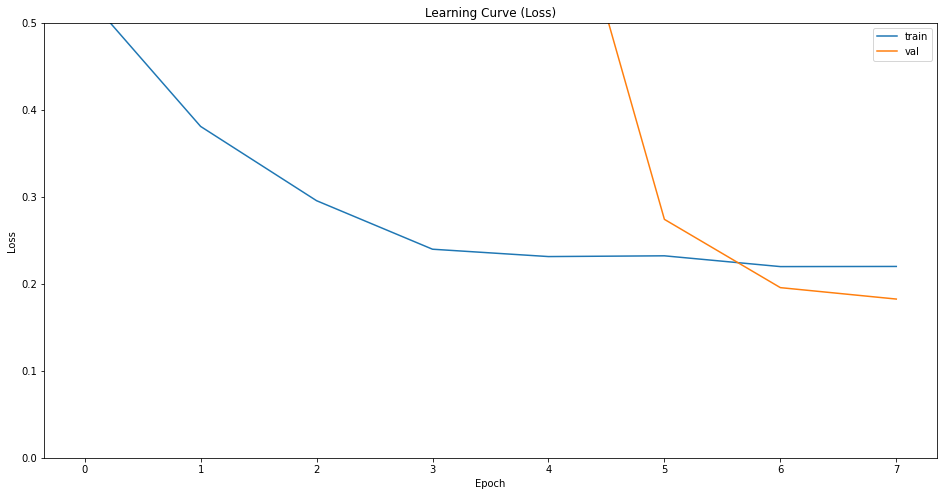

In [35]:
# Loss 학습 곡선
fig, ax = plt.subplots(figsize = (16, 8))

sns.lineplot(x = fit_model.epoch, y = fit_model.history['loss'])
sns.lineplot(x = fit_model.epoch, y = fit_model.history['val_loss'])

ax.set_title('Learning Curve (Loss)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc = 'best')

plt.show()

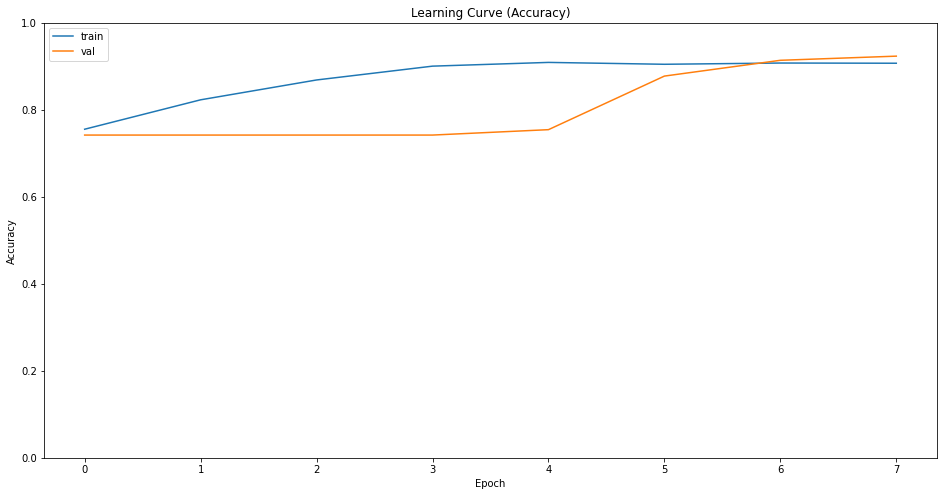

In [36]:
# Accuracy 학습 곡선
fig, ax = plt.subplots(figsize = (16, 8))

sns.lineplot(x = fit_model.epoch, y = fit_model.history['binary_accuracy'])
sns.lineplot(x = fit_model.epoch, y = fit_model.history['val_binary_accuracy'])

ax.set_title('Learning Curve (Accuracy)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim(0, 1)
ax.legend(['train', 'val'], loc = 'best')

plt.show()

In [37]:
val_score = model.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)

print('val loss: ', val_score[0])
print('val accuracy: ', val_score[1])

val loss:  0.1825089007616043
val accuracy:  0.9235911965370178


In [38]:
test_score = model.evaluate(ds_test, steps = len(df_test), verbose = 0)

print('test loss: ', test_score[0])
print('test accuracy: ', test_score[1])

test loss:  0.4775913953781128
test accuracy:  0.817307710647583


In [39]:
# 전이 학습
base_model = tf.keras.applications.ResNet152V2(
    weights = 'imagenet',
    input_shape = (IMG_SIZE, IMG_SIZE, 3),
    include_top = False
)

base_model.trainable = False

234561536/234545216 [==============================] - 2s 0us/step


In [40]:
def get_pretrained():
    
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)) # width, height, color channels
    
    x = base_model(inputs)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [41]:
keras.backend.clear_session()

model_pre = get_pretrained()
model_pre.compile(loss = 'binary_crossentropy',
                  optimizer = keras.optimizers.Adam(learning_rate = 4e-5),
                  metrics = 'binary_accuracy')

model_pre.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [42]:
model_pre_fit = model_pre.fit(ds_train, batch_size = BATCH, epochs = 8, validation_data = ds_val,
                              callbacks = [early_stopping, reduce_plateau],
                              steps_per_epoch = (len(train_df)/BATCH),
                              validation_steps = (len(val_df)/BATCH))

Epoch 1/8
130/130 [==============================] - 2175s 17s/step - loss: 0.4823 - binary_accuracy: 0.7665 - val_loss: 0.2589 - val_binary_accuracy: 0.9093 - lr: 4.0000e-05
Epoch 2/8
130/130 [==============================] - 2140s 16s/step - loss: 0.2349 - binary_accuracy: 0.9147 - val_loss: 0.1893 - val_binary_accuracy: 0.9284 - lr: 4.0000e-05
Epoch 3/8
130/130 [==============================] - 2156s 17s/step - loss: 0.1882 - binary_accuracy: 0.9324 - val_loss: 0.1675 - val_binary_accuracy: 0.9417 - lr: 4.0000e-05
Epoch 4/8
130/130 [==============================] - 2141s 16s/step - loss: 0.1716 - binary_accuracy: 0.9376 - val_loss: 0.1453 - val_binary_accuracy: 0.9475 - lr: 4.0000e-05
Epoch 5/8
130/130 [==============================] - 2128s 16s/step - loss: 0.1539 - binary_accuracy: 0.9434 - val_loss: 0.1344 - val_binary_accuracy: 0.9503 - lr: 4.0000e-05
Epoch 6/8
130/130 [==============================] - 2118s 16s/step - loss: 0.1485 - binary_accuracy: 0.9453 - val_loss: 0.13

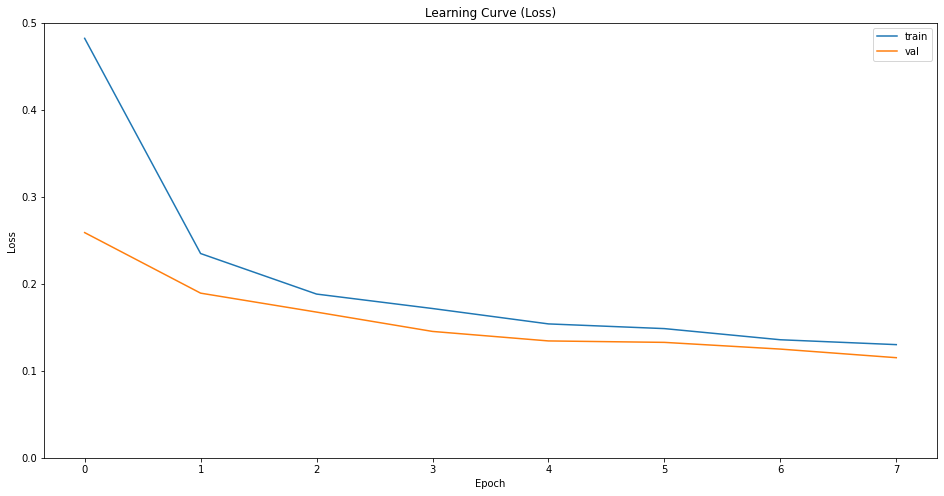

In [43]:
# 전이 학습 loss 학습 곡선
fig, ax = plt.subplots(figsize = (16, 8))

sns.lineplot(x = model_pre_fit.epoch, y = model_pre_fit.history['loss'])
sns.lineplot(x = model_pre_fit.epoch, y = model_pre_fit.history['val_loss'])

ax.set_title('Learning Curve (Loss)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc = 'best')

plt.show()

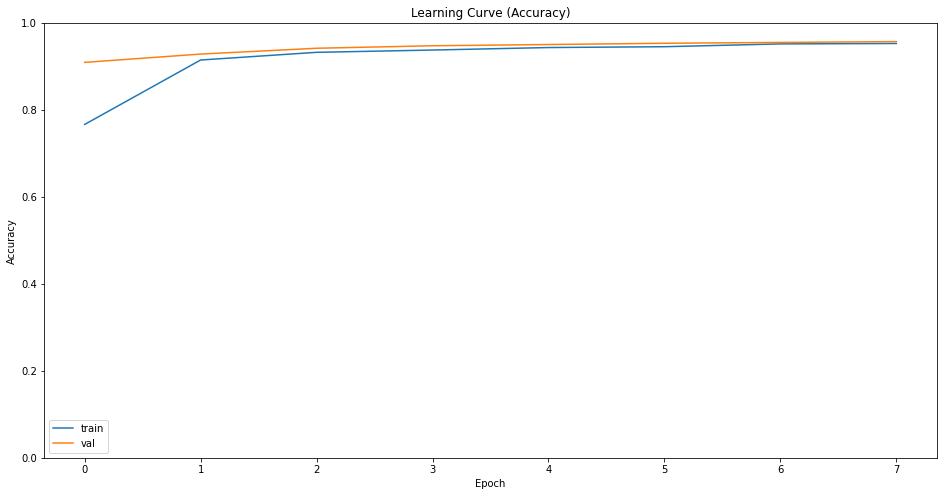

In [44]:
# 전이 학습 accuracy 학습 곡선
fig, ax = plt.subplots(figsize = (16, 8))

sns.lineplot(x = model_pre_fit.epoch, y = model_pre_fit.history['binary_accuracy'])
sns.lineplot(x = model_pre_fit.epoch, y = model_pre_fit.history['val_binary_accuracy'])

ax.set_title('Learning Curve (Accuracy)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim(0, 1)
ax.legend(['train', 'val'], loc = 'best')

plt.show()

In [45]:
val_score = model_pre.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)

print('val loss: ', val_score[0])
print('val accuracy: ', val_score[1])

val loss:  0.11509774625301361
val accuracy:  0.9570200443267822


In [46]:
test_score = model_pre.evaluate(ds_test, steps = len(df_test), verbose = 0)

print('test loss: ', test_score[0])
print('test accuracy: ', test_score[1])

test loss:  0.3351423144340515
test accuracy:  0.8541666865348816


In [47]:
# 미세 조정
base_model.trainable = True

for layer in base_model.layers[:-13]:
  layer.trainable = False

In [48]:
# 조정 가능한 레이어 확인
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [49]:
model_pre.compile(loss = 'binary_crossentropy',
                  optimizer = keras.optimizers.Adam(learning_rate = 2e-6),
                  metrics = 'binary_accuracy')

model_pre.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [50]:
model_pre_fit = model_pre.fit(ds_train, batch_size = BATCH, epochs = 8, validation_data = ds_val,
                              callbacks = [early_stopping, reduce_plateau],
                              steps_per_epoch = (len(train_df)/BATCH),
                              validation_steps = (len(val_df)/BATCH))

Epoch 1/8
130/130 [==============================] - 2276s 17s/step - loss: 0.2119 - binary_accuracy: 0.9305 - val_loss: 0.1711 - val_binary_accuracy: 0.9522 - lr: 2.0000e-06
Epoch 2/8
130/130 [==============================] - 2264s 17s/step - loss: 0.1914 - binary_accuracy: 0.9357 - val_loss: 0.1627 - val_binary_accuracy: 0.9503 - lr: 2.0000e-06
Epoch 3/8
130/130 [==============================] - 2272s 17s/step - loss: 0.1675 - binary_accuracy: 0.9496 - val_loss: 0.1508 - val_binary_accuracy: 0.9513 - lr: 2.0000e-06
Epoch 4/8
130/130 [==============================] - 2261s 17s/step - loss: 0.1617 - binary_accuracy: 0.9486 - val_loss: 0.1451 - val_binary_accuracy: 0.9503 - lr: 2.0000e-06
Epoch 5/8
130/130 [==============================] - 2272s 17s/step - loss: 0.1530 - binary_accuracy: 0.9496 - val_loss: 0.1336 - val_binary_accuracy: 0.9580 - lr: 2.0000e-06
Epoch 6/8
130/130 [==============================] - 2255s 17s/step - loss: 0.1487 - binary_accuracy: 0.9477 - val_loss: 0.12

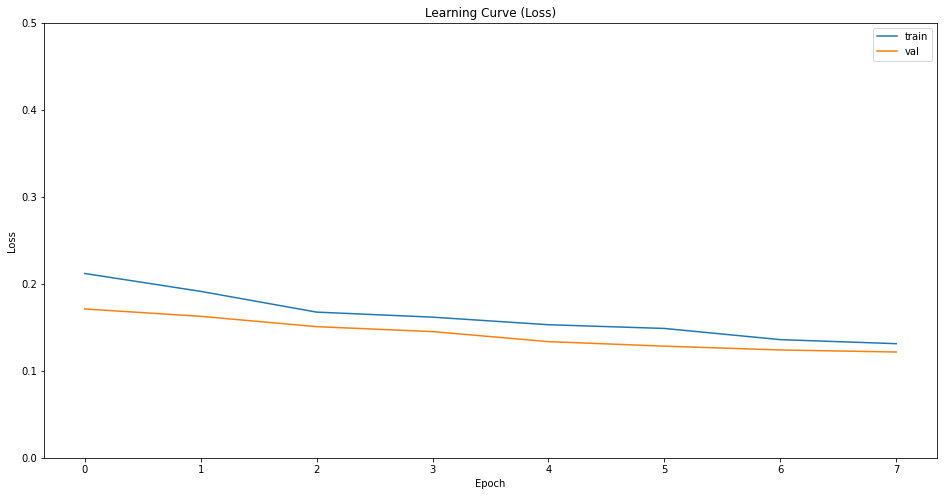

In [51]:
# 미세조정 후 전이 학습 loss 학습 곡선
fig, ax = plt.subplots(figsize = (16, 8))

sns.lineplot(x = model_pre_fit.epoch, y = model_pre_fit.history['loss'])
sns.lineplot(x = model_pre_fit.epoch, y = model_pre_fit.history['val_loss'])

ax.set_title('Learning Curve (Loss)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc = 'best')

plt.show()

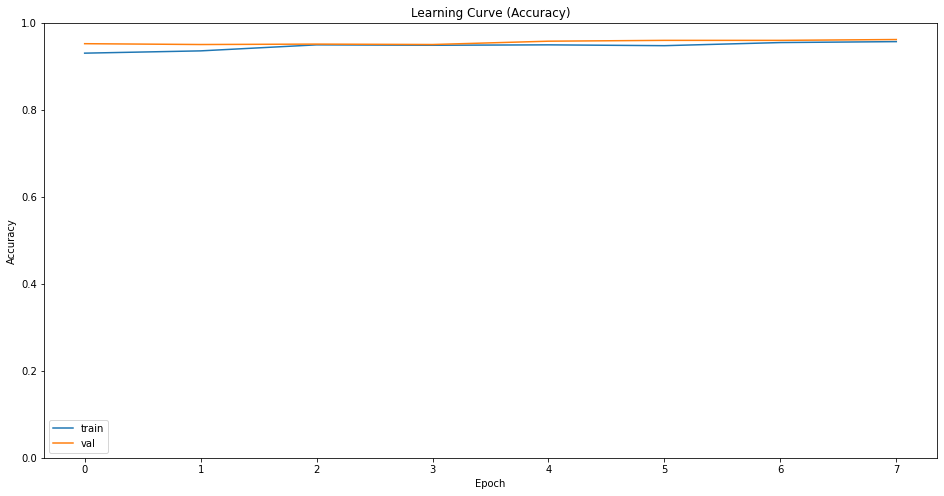

In [52]:
# 미세 조정 후 전이 학습 accuracy 학습 곡선
fig, ax = plt.subplots(figsize = (16, 8))

sns.lineplot(x = model_pre_fit.epoch, y = model_pre_fit.history['binary_accuracy'])
sns.lineplot(x = model_pre_fit.epoch, y = model_pre_fit.history['val_binary_accuracy'])

ax.set_title('Learning Curve (Accuracy)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim(0, 1)
ax.legend(['train', 'val'], loc = 'best')

plt.show()

In [53]:
val_score = model_pre.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)

print('val loss: ', val_score[0])
print('val accuracy: ', val_score[1])

val loss:  0.12163814157247543
val accuracy:  0.9617956280708313


In [54]:
test_score = model_pre.evaluate(ds_test, steps = len(df_test), verbose = 0)

print('test loss: ', test_score[0])
print('test accuracy: ', test_score[1])

test loss:  0.25598224997520447
test accuracy:  0.9070512652397156


미세 조정 접근 방식이 가장 높은 점수에 도달

In [57]:
df_test['class']

0          Normal
1          Normal
2          Normal
3          Normal
4          Normal
          ...    
619    Pneumonnia
620    Pneumonnia
621    Pneumonnia
622    Pneumonnia
623    Pneumonnia
Name: class, Length: 624, dtype: object

In [58]:
# 성능 지표
label = {'Normal': 0, 'Pneumonnia': 1}
y_test = df_test['class'].copy().map(label).astype('int')

In [59]:
ds_test.reset()
predictions = model_pre.predict(ds_test, steps = len(ds_test), verbose = 0)
pred_labels = np.where(predictions > 0.5, 1, 0) # 조건에 맞는 값 찾기

In [60]:
print('test accuracy: ', accuracy_score(y_test, pred_labels))

test accuracy:  0.907051282051282


In [66]:
print(metrics.classification_report(y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.96      0.78      0.86       234
           1       0.88      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.88      0.90       624
weighted avg       0.91      0.91      0.90       624



100% 에 가까운 recall 

꽤 좋은 recall 에 도달했기 때문에 모델의 기능이 잘 나타난다고 할 수 있음